# Extract data from output files

### Code to extract timing information from output files of Lbann code
March 9, 2020

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import subprocess as sp
import os
import glob

## Extract training times

In [4]:
def f_get_output(fname):
    ''' Use grep to get run times from output files
    '''
    cmd='grep "run time" {0}| grep "training"'.format(fname)
    op1=sp.check_output(cmd,shell=True).decode('utf-8').split('\n')[:-1]
    # print(op1)

    cmd='grep "run time" {0}| grep "validation"'.format(fname)
    op2=sp.check_output(cmd,shell=True).decode('utf-8').split('\n')[:-1]
    
    return op1,op2

def f_get_run_times(op_arr):
    '''
    Get run times from output file out.log
    '''
    run_times=np.array([np.float(i.split(':')[-1][:-1]) for i in op_arr])
    return run_times

def f_print_run_times(fname):
    
    ### Get output 
    op1,op2=f_get_output(fname)
    ### Get arrays from outputs for training and validation
    arr1=f_get_run_times(op1)
    arr2=f_get_run_times(op2)
    ### Print times
    print("Training times: {0}\nValidation times: {1}".format(arr1,arr2))
    print("Number of epochs",len(arr1))
    print("Mean times:",np.mean(arr1),np.mean(arr2),'\n')
    


In [5]:

def f_store_run_times(fname):
    
    ### Get output 
    op1,op2=f_get_output(fname)
    ### Get arrays from outputs for training and validation
    arr1=f_get_run_times(op1)
    arr2=f_get_run_times(op2)
    ### Print times
    size=len(arr1) ### Number of epochs
    ### Compute mean and errors of times
    train_mean,train_err=np.mean(arr1),np.std(arr1)/np.sqrt(size)
    val_mean,val_err=np.mean(arr2),np.std(arr2)/np.sqrt(size)
    
    
    ### Extract processor info from the file name
    try:
        lst=fname.split('/')[-1].split('.')[0].split('_')
        nodes,procs,cpus=int(lst[1]),int(lst[2]),int(lst[3])
    except Exception as e:
        print(e,fle)
        nodes,procs,cpus=None,None,None
        pass
    
    job_strg='_'.join(fname.split('/')[-1].split('.')[0].split('-')[-1].split('_')[1:])
    
    keys=['train_arr','val_arr','train_mean','train_err','val_mean','val_err','num_epochs','nodes','GPUs_per_node','cpus','job_strg']
    values=[arr1,arr2,train_mean,train_err,val_mean,val_err,size,nodes,procs,cpus,job_strg]
    info_dict=dict(zip(keys,values))
    
#     print(info_dict)
    return info_dict


In [6]:
# fname=main_dir+'20200309_161923_exagan/out.log'
# f_store_run_times(fname)

In [7]:
# main_dir='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_data/'
# for fldr in glob.glob(main_dir+'20200309_*'):
#     print(fldr.split('/')[-1])
#     fname=fldr+'/out.log'
#     f_print_run_times(fname)

In [20]:
main_dir='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_data/'

df=pd.DataFrame([])

for fle in glob.glob(main_dir+'20200318_131818*/collected_outputs/slurm-*_*.out'):
#     print(fle)
    info_dict=f_store_run_times(fle)
    df=df.append(info_dict,ignore_index=True)
    
df=df.sort_values(by=['nodes','GPUs_per_node']).reset_index(drop=True)
df

,GPUs_per_node,cpus,job_strg,nodes,num_epochs,train_arr,train_err,train_mean,val_arr,val_err,val_mean
0,1.0,16.0,1_1_16,1.0,50.0,"[58.0368, 54.0055, 53.9951, 54.0105, 54.1736, ...",0.248796,55.339312,"[6.45492, 6.12053, 6.06836, 6.05024, 6.1011, 6...",0.029757,6.272653
1,2.0,4.0,1_2_4,1.0,50.0,"[27.8979, 24.6413, 24.6628, 24.7362, 24.9883, ...",0.062180,24.948990,"[2.46145, 2.23464, 2.1944, 2.24249, 2.24753, 2...",0.009217,2.267410
2,3.0,4.0,1_3_4,1.0,50.0,"[21.2509, 18.3791, 18.5992, 18.6859, 18.6615, ...",0.059130,18.655350,"[1.87872, 1.73551, 1.79548, 1.77948, 1.70993, ...",0.007468,1.763772
3,4.0,4.0,1_4_4,1.0,50.0,"[17.2072, 15.2023, 15.0594, 15.2377, 15.0305, ...",0.046284,15.145230,"[1.59158, 1.40315, 1.38168, 1.37896, 1.39059, ...",0.007512,1.394215
4,6.0,4.0,1_6_4,1.0,50.0,"[13.0091, 10.0231, 9.98954, 10.019, 10.0658, 1...",0.065810,9.933276,"[1.2023, 1.2239, 1.11112, 1.18596, 1.11894, 1....",0.012429,1.079953
5,8.0,4.0,1_8_4,1.0,50.0,"[17.8268, 15.1447, 9.89176, 9.47522, 9.40823, ...",0.355702,10.996650,"[1.82262, 1.66964, 1.07393, 0.906741, 0.897599...",0.046309,1.157771
6,2.0,4.0,2_2_4,2.0,22.0,"[22.0042, 19.9488, 20.0078, 19.2956, 19.5748, ...",0.119477,19.709832,"[1.64034, 1.47953, 1.49941, 1.56034, 1.4776, 1...",0.014002,1.487260
7,3.0,4.0,2_3_4,2.0,15.0,"[18.7944, 15.7085, 16.2991, 15.6435, 15.6608, ...",0.201755,16.121047,"[1.41622, 1.21161, 1.24933, 1.26913, 1.21022, ...",0.013389,1.239645
8,4.0,4.0,2_4_4,2.0,50.0,"[16.2207, 13.6488, 13.6984, 13.729, 13.34, 13....",0.056901,13.591426,"[1.0667, 0.968617, 0.959261, 0.950917, 0.91976...",0.005386,0.963677
9,2.0,4.0,3_2_4,3.0,10.0,"[18.757, 16.0605, 16.0693, 16.0786, 16.1615, 1...",0.261544,16.291700,"[1.42321, 1.32532, 1.21246, 1.25569, 1.36024, ...",0.020894,1.295398


In [21]:
col_list=['job_strg','GPUs_per_node','nodes','train_mean','train_err']
df[col_list]

,job_strg,GPUs_per_node,nodes,train_mean,train_err
0,1_1_16,1.0,1.0,55.339312,0.248796
1,1_2_4,2.0,1.0,24.948990,0.062180
2,1_3_4,3.0,1.0,18.655350,0.059130
3,1_4_4,4.0,1.0,15.145230,0.046284
4,1_6_4,6.0,1.0,9.933276,0.065810
5,1_8_4,8.0,1.0,10.996650,0.355702
6,2_2_4,2.0,2.0,19.709832,0.119477
7,2_3_4,3.0,2.0,16.121047,0.201755
8,2_4_4,4.0,2.0,13.591426,0.056901
9,3_2_4,2.0,3.0,16.291700,0.261544


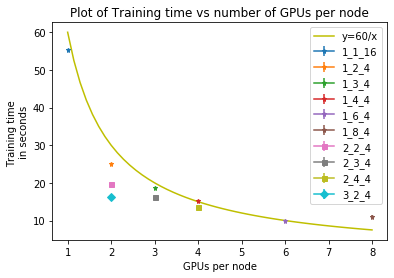

In [32]:
### Scaling plot 1
plt.figure()
for i,j in df.iterrows():
    x,y,yerr=j.GPUs_per_node,j.train_mean,j.train_err
    markers_dict={'1':'*','2':'s','3':'D','4':'h'}
    marker=markers_dict[str(int(j.nodes))]
    plt.errorbar(x=x,y=y,yerr=yerr,label=j.job_strg,markersize=5,marker=marker)
    
### Comparison with expected scaling
x=np.linspace(1,8,num=50)
plt.plot(x,60.0/x,color='y',label='y=60/x')
plt.xlabel('GPUs per node')
plt.ylabel('Training time \nin seconds')
plt.title('Plot of Training time vs number of GPUs per node')
plt.legend()
plt.title('Plot of Training time vs number of GPUs per node')

plt.savefig('scalingplot1.png')

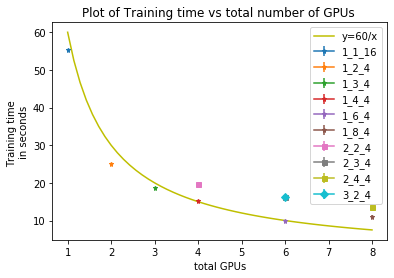

In [33]:
### Scaling plot 2
plt.figure()
for i,j in df.iterrows():
    x,y,yerr=j.GPUs_per_node*j.nodes,j.train_mean,j.train_err
    
    markers_dict={'1':'*','2':'s','3':'D','4':'h'}
    marker=markers_dict[str(int(j.nodes))]
    plt.errorbar(x=x,y=y,yerr=yerr,label=j.job_strg,markersize=5,marker=marker)
    
### Comparison with expected scaling
x=np.linspace(1,8,num=50)
plt.plot(x,60.0/x,color='y',label='y=60/x')
plt.xlabel('total GPUs')
plt.ylabel('Training time \nin seconds')
plt.title('Plot of Training time vs number of GPUs per node')
plt.legend()
plt.title('Plot of Training time vs total number of GPUs ')

plt.savefig('scalingplot2.png')

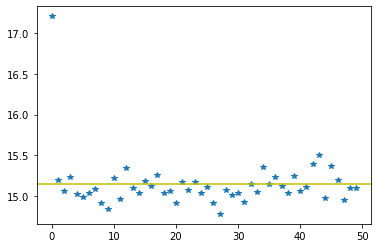

In [34]:
### Plot individual times
plt.figure()
y=df[df.job_strg=='1_4_4'].train_arr.values[0]
plt.plot(y,linestyle='',marker='*')
plt.axhline(np.mean(y),color='y')